# Abstract Generation from COVID-19 dataset
For this task, I have chosen LSTM.

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
!pip install tensorflow

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
import gdown # To download the file from Google Drive
import json
import re
import pandas as pd
import numpy as np
import random
import zipfile
import os
import glob
import multiprocessing
from multiprocessing import Pool, cpu_count, Lock
from functools import partial
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from IPython.display import display, Math

## Getting the file from GDrive

In [ ]:
file_id = '1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE
From (redirected): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE&confirm=t&uuid=35da7e90-14b7-4ce7-b791-4a276b20d6df
To: /content/dataset.zip
100%|██████████| 1.00G/1.00G [00:05<00:00, 194MB/s]


'dataset.zip'

## File Extraction and setting path for access

In [ ]:
zip_file_path = 'dataset.zip'
extraction_dir_all = '/content/dataset_all'
extraction_dir_100 = '/content/dataset_100'

# Create directories with all and first 100 files
os.makedirs(extraction_dir_all, exist_ok=True)
os.makedirs(extraction_dir_100, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = [file for file in zip_ref.namelist() if not file.endswith('/')]
    print(f"Number of files in zip: {len(file_list)}")

    # Limit to the first 100 files
    files_to_extract_100 = file_list[:100]

    # Extract first 100 files into the dataset_100 folder
    with tqdm(total=len(files_to_extract_100), desc='Extracting first 100 files') as pbar:
        for i, file in enumerate(files_to_extract_100):
            # Create a custom file name for the first 100 files
            new_filename_100 = f"{i + 1}_{os.path.basename(file)}"
            new_filepath_100 = os.path.join(extraction_dir_100, new_filename_100)

            # Extract the file to the new location with the new name
            with zip_ref.open(file) as source_file, open(new_filepath_100, 'wb') as dest_file:
                dest_file.write(source_file.read())

            pbar.update(1)

    # Extract all files into the dataset_all folder (skip directories)
    with tqdm(total=len(file_list), desc='Extracting all files') as pbar:
        for i, file in enumerate(file_list):
            new_filepath_all = os.path.join(extraction_dir_all, os.path.basename(file))

            # Extract the file to the new location with the original name
            with zip_ref.open(file) as source_file, open(new_filepath_all, 'wb') as dest_file:
                dest_file.write(source_file.read())

            pbar.update(1)

Number of files in zip: 56529


Extracting all files: 100%|██████████| 56529/56529 [00:52<00:00, 1077.44it/s]


## Extracting all texts from all abstracts

In [ ]:
# Add this to create 'pdf_json' subdirectory if they don't exist
os.makedirs(os.path.join(extraction_dir_all, 'pdf_json'), exist_ok=True)
os.makedirs(os.path.join(extraction_dir_100, 'pdf_json'), exist_ok=True)

all_json_files = [f for f in os.listdir(extraction_dir_all) if f.endswith('.json') and not f.endswith('.swp')]
json_100_files = [f for f in os.listdir(extraction_dir_100) if f.endswith('.json') and not f.endswith('.swp')]

# Function to process each JSON file
def process_file(extraction, file_name):
    file_path = os.path.join(extraction, file_name)
    text_data = []

    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

            # Function to find "title" and "text", excluding certain contexts
            def extract_text(data):
                if isinstance(data, dict):
                    # Extract "abstract" and "body_text" text
                    if 'abstract' in data:
                        abstract = data['abstract']
                        if isinstance(abstract, list):
                            for item in abstract:
                                if isinstance(item, dict) and 'text' in item:
                                    text = item['text']
                                    if isinstance(text, str):
                                        text_data.append(text)

                    # Check and skip "cite_spans"
                    if 'cite_spans' in data:
                        # Skip extraction from "cite_spans"
                        return

                    for key, value in data.items():
                        extract_text(value)
                elif isinstance(data, list):
                    for item in data:
                        extract_text(item)

            extract_text(data)
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

    return text_data

# Use multiprocessing to process files in parallel
def parallel_process(extraction, files, num_workers=4):
    # Create a partial function that binds the 'extraction' argument to 'process_file'
    process_with_extraction = partial(process_file, extraction)

    with multiprocessing.Pool(num_workers) as pool:
        results = list(tqdm(pool.imap(process_with_extraction, files), total=len(files)))

    return results

In [ ]:
# Add this to create 'dataset' subdirectory if they don't exist
os.makedirs('/content/dataset', exist_ok=True)

corpus_file_path_all = '/content/corpus_all.txt'
corpus_file_path_100 = '/content/corpus_100.txt'
results_all = parallel_process(extraction_dir_all, all_json_files, num_workers=4)
results_100 = parallel_process(extraction_dir_100, json_100_files, num_workers=4)

# Flatten the list of results and combine all text
corpus_all = [text for sublist in results_all for text in sublist]
corpus_100 = [text for sublist in results_100 for text in sublist]

# Save the corpus to a text file
with open('/content/dataset/corpus_100.txt', 'w', encoding='utf-8') as corpus_file:
    for text in corpus_100:
        corpus_file.write(text + '\n')
with open('/content/dataset/corpus_all.txt', 'w', encoding='utf-8') as corpus_file:
    for text in corpus_all:
        corpus_file.write(text + '\n')

100%|██████████| 100/100 [00:00<00:00, 4311.67it/s]


In [ ]:
input_100_file_path = '/content/dataset/corpus_100.txt'
output_100_file_path = '/content/dataset/corpus_cleaned_100.txt'
input_all_file_path = '/content/dataset/corpus_all.txt'
output_all_file_path = '/content/dataset/corpus_cleaned_all.txt'

In [ ]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Function to check if a token contains any alphabetic characters and no numbers
def contains_alphabet_and_no_numbers(token):
    return any(char.isalpha() for char in token) and not any(char.isdigit() for char in token)

# Function to remove tokens that do not contain any alphabetic characters and contain numbers
def remove_non_alpha_and_numbers_tokens(tokens):
    return [
        token for token in tokens
        if (contains_alphabet_and_no_numbers(token) and
            not re.search(r'[\u0370-\u03FF]', token) and
            not re.fullmatch(r"\w*'s", token) and
            token not in stop_words)
    ]

# Function to remove punctuation from the tokens
def remove_punctuation(tokens):
    return [token for token in tokens if token not in string.punctuation]

# Function to remove URLs from the text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

# Function to clean and process each line
def process_line(line):
    line = line.lower()
    line = remove_urls(line)

    tokens = word_tokenize(line)
    tokens = remove_punctuation(tokens)

    cleaned_tokens = remove_non_alpha_and_numbers_tokens(tokens)

    # Remove words shorter than 3 characters
    cleaned_tokens = [token for token in cleaned_tokens if len(token) >= 3]

    cleaned_line = ' '.join(cleaned_tokens)

    return cleaned_line if cleaned_line.strip() else None

In [ ]:
def main():
    input_100_file_path = '/content/dataset/corpus_100.txt'
    output_100_file_path = '/content/dataset/corpus_cleaned_100.txt'
    input_all_file_path = '/content/dataset/corpus_all.txt'
    output_all_file_path = '/content/dataset/corpus_cleaned_all.txt'

    with open(input_100_file_path, 'r') as file:
        lines = file.readlines()

    with Pool(cpu_count()) as pool:
        processed_lines = list(tqdm(pool.imap(process_line, lines), total=len(lines), desc='Processing Lines'))

    with open(output_100_file_path, 'w') as file:
        for line in processed_lines:
            if line:
                file.write(line + '\n')

    print(f"Cleaned text has been saved to {output_100_file_path}.")

    with open(input_all_file_path, 'r') as file:
        lines = file.readlines()

    with Pool(cpu_count()) as pool:
        processed_lines = list(tqdm(pool.imap(process_line, lines), total=len(lines), desc='Processing Lines'))

    with open(output_all_file_path, 'w') as file:
        for line in processed_lines:
            if line:
                file.write(line + '\n')

    print(f"Cleaned text has been saved to {output_all_file_path}.")
if __name__ == "__main__":
    main()

Processing Lines: 100%|██████████| 111/111 [00:01<00:00, 100.18it/s]


Cleaned text has been saved to /content/dataset/corpus_cleaned_100.txt.


Processing Lines: 100%|██████████| 78470/78470 [00:36<00:00, 2162.96it/s]


Cleaned text has been saved to /content/dataset/corpus_cleaned_all.txt.


## Assignment 6 - Architecture and describe the architecture
Implement a small language model with a minimum of two hidden states consisting of a forward and
backward pass

### Language Model Architecture

The language model utilizes a Bidirectional Long Short-Term Memory (LSTM) architecture. It consists of the following layers:

1. **Embedding Layer:** This layer transforms words into numerical vector representations called embeddings, capturing their semantic meaning.
2. **Bidirectional LSTM Layers:** These layers form the core of the model, processing the sequence of word embeddings in both forward and backward directions. This bidirectional approach allows the model to capture contextual information from both past and future words, enhancing its understanding of the text. Two such layers are stacked to further improve the model's ability to capture complex dependencies.
3. **Dense Layer:** A final dense layer, equipped with a softmax activation function, predicts the next word in the sequence. This layer outputs a probability distribution over the entire vocabulary, with the word having the highest probability being selected as the prediction.


### Loss Function

The model is trained using the **sparse categorical cross-entropy** loss function, suitable for predicting the next word from a sequence.

## Assignment 7 - Training and plotting
**Input** : Abstracts from the COVID-19 corpus. Experiment with a hundred abstracts before extending to
the entire corpus. Plot the error graph during the training process.

For this purpose, I have created the following files:

- `corpus_cleaned_100.txt`
- `corpus_cleaned_all.txt`


In [ ]:
# Load the text file
with open('/content/dataset/corpus_cleaned_100.txt', 'r', encoding='utf-8') as file:
    text_data_100 = file.read()

# Load the text file
with open('/content/dataset/corpus_cleaned_all.txt', 'r', encoding='utf-8') as file:
    text_data_all = file.read()

# Strip any unwanted newline characters or extra spaces from the text
text_data_100 = [text.strip() for text in text_data_100]
text_data_all = [text.strip() for text in text_data_all]

### Prepare the Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer_100 = Tokenizer()
tokenizer_all = Tokenizer()

# Fit the tokenizer on the text data
tokenizer_100.fit_on_texts([text_data_100])
tokenizer_all.fit_on_texts([text_data_all])

# Define the vocabulary size (number of unique tokens + 1 for padding)
vocab_size = len(tokenizer_100.word_index) + 1  # +1 for padding index
vocab_size_all = len(tokenizer_all.word_index) + 1  # +1 for padding index

### Set the Hyperparameters

In [ ]:
embed_size = 64   # Embedding dimension
hidden_size = 128  # Hidden size for LSTM layers
num_layers = 2     # Number of LSTM layers
drop_out = 0.3     # Dropout rate

### Prepare the Data

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function for tokenization, used in parallel processing
def tokenize_data(text_data, tokenizer):
    return tokenizer.texts_to_sequences(text_data)

# Tokenize the text data in parallel using multiprocessing
def parallel_tokenize(data, tokenizer, num_workers=4):
    # Split data into chunks for parallel processing
    chunk_size = len(data) // num_workers
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    with Pool(num_workers) as pool:
        result = list(tqdm(pool.starmap(tokenize_data, [(chunk, tokenizer) for chunk in chunks]), total=len(chunks), desc="Tokenizing"))

    # Combine the results from the chunks
    return [item for sublist in result for item in sublist]

# Tokenize the text data with progress bar
print("Tokenizing text_data_100 with tqdm and multiprocessing...")
sequences = parallel_tokenize(text_data_100, tokenizer_100)

print("Tokenizing text_data_all with tqdm and multiprocessing...")
sequences_all = parallel_tokenize(text_data_all, tokenizer_all)

# Pad the sequences to ensure uniform length
maxlen = 50
padded_sequences = pad_sequences(sequences, maxlen=maxlen)
padded_sequences_all = pad_sequences(sequences_all, maxlen=maxlen)

# Define input and target data
X = padded_sequences[:, :-1]  # Input sequence (exclude the last word)
y = padded_sequences[:, 1:]   # Output sequence (exclude the first word)

X_all = padded_sequences_all[:, :-1]  # All tokens except the last one
y_all = padded_sequences_all[:, 1:]   # All tokens except the first one

print(f'Shape of X and y for first 100 abstracts {X.shape, y.shape}')
print(f'Shape of X and y for all abstracts {X_all.shape, y_all.shape}')

Tokenizing text_data_100 with tqdm and multiprocessing...


Tokenizing: 100%|██████████| 4/4 [00:00<00:00, 21536.86it/s]


Tokenizing text_data_all with tqdm and multiprocessing...


Tokenizing: 100%|██████████| 4/4 [00:00<00:00, 35848.75it/s]


Shape of X and y for first 100 abstracts ((68928, 49), (68928, 49))
Shape of X and y for all abstracts ((43842248, 49), (43842248, 49))


## Build the Model

### First testing with 100 abstracts

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Connect to the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)  # Connect the session to the TPU cluster
tf.tpu.experimental.initialize_tpu_system(resolver)  # Initialize the TPU system

# Create a TPU strategy to distribute the training across TPU cores
strategy = tf.distribute.TPUStrategy(resolver)  # Create a strategy for distributing across TPU cores

In [ ]:
X_shape = X.shape[1]
# Initialize the model using the TPU strategy scope
with strategy.scope():
    model = Sequential()

    # Add the embedding layer
    model.add(Embedding(input_dim=vocab_size,  # Size of vocabulary
                        output_dim=embed_size,  # Size of embedding vectors
                        input_length=X_shape))  # Length of input sequences

    # Add stacked Bidirectional LSTM layers
    for _ in range(num_layers):
        model.add(Bidirectional(LSTM(hidden_size, return_sequences=True, dropout=drop_out)))

    # Add a Dense layer for predicting the next word (or any task-specific output)
    model.add(Dense(vocab_size, activation='softmax'))  # Output layer for classification (word prediction)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 49, 64)            2496      
                                                                 
 bidirectional (Bidirection  (None, 49, 256)           197632    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 49, 256)           394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 49, 39)            10023     
                                                                 
Total params: 604391 (2.31 MB)
Trainable params: 604391 (2.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Prepare dataset
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)  # Adjust batch size as needed

# Callbacks: Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', save_weights_only=False)

In [ ]:
dataset = dataset.shuffle(buffer_size=1000)

# Split ratio
train_ratio = 0.8

# Calculate number of elements in the training set
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into train and validation
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# Check if the datasets have the expected sizes
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

# Training the model with callbacks and validation data
model.fit(
    train_dataset,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    validation_data=val_dataset,
    shuffle=True  # Shuffle the training data
)

model.save('my_model.keras')

Train dataset size: 431
Validation dataset size: 108
Epoch 1/10
431/431 [==============================] - 35s 54ms/step - loss: 0.1096 - accuracy: 0.9798 - val_loss: 0.0596 - val_accuracy: 0.9820
Epoch 2/10
431/431 [==============================] - 14s 33ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.0594 - val_accuracy: 0.9820
Epoch 3/10
431/431 [==============================] - 14s 32ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.0593 - val_accuracy: 0.9820
Epoch 4/10
431/431 [==============================] - 13s 30ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.0594 - val_accuracy: 0.9821
Epoch 5/10
431/431 [==============================] - 13s 30ms/step - loss: 0.0593 - accuracy: 0.9820 - val_loss: 0.0594 - val_accuracy: 0.9821
Epoch 6/10
431/431 [==============================] - 13s 31ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.0591 - val_accuracy: 0.9821
Epoch 7/10
431/431 [==============================] - 13s 30ms/step - loss: 0.0593 

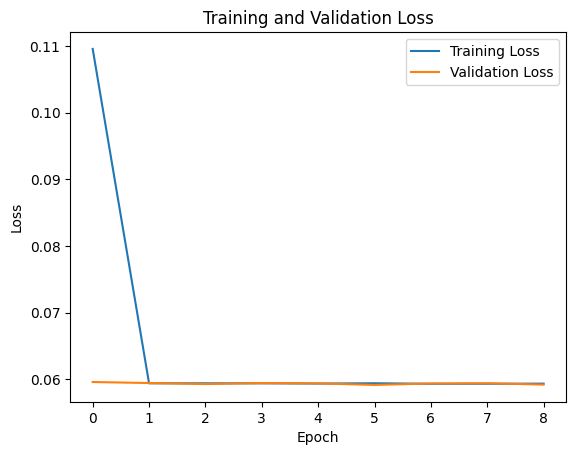

In [ ]:
# Access the history object from the model.fit() method
history = model.history.history

# Plot the training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Testing with full dataset

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Connect to the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)  # Connect the session to the TPU cluster
tf.tpu.experimental.initialize_tpu_system(resolver)  # Initialize the TPU system

# Create a TPU strategy to distribute the training across TPU cores
strategy = tf.distribute.TPUStrategy(resolver)  # Create a strategy for distributing across TPU cores

In [ ]:
X_shape = X_all.shape[1]
# Initialize the model using the TPU strategy scope
with strategy.scope():
    model = Sequential()

    # Add the embedding layer
    model.add(Embedding(input_dim=vocab_size_all,  # Size of vocabulary
                        output_dim=embed_size,  # Size of embedding vectors
                        input_length=X_shape))  # Length of input sequences

    # Add stacked Bidirectional LSTM layers
    for _ in range(num_layers):
        model.add(Bidirectional(LSTM(hidden_size, return_sequences=True, dropout=drop_out)))

    # Add a Dense layer for predicting the next word (or any task-specific output)
    model.add(Dense(vocab_size_all, activation='softmax'))  # Output layer for classification (word prediction)

    optimizer = Adam(learning_rate=0.005) # Change the learning rate here
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 49, 64)            43584     
                                                                 
 bidirectional (Bidirection  (None, 49, 256)           197632    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 49, 256)           394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 49, 681)           175017    
                                                                 
Total params: 810473 (3.09 MB)
Trainable params: 810473 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batch_size = 4096
dataset = tf.data.Dataset.from_tensor_slices((X_all, y_all))
dataset = dataset.batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)  # Adjust batch size as needed

# Callbacks: Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', save_weights_only=False)

In [ ]:
dataset = dataset.shuffle(buffer_size=1000)

# Split ratio
train_ratio = 0.8

# Calculate number of elements in the training set
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into train and validation
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# Check if the datasets have the expected sizes
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

# Training the model with callbacks and validation data
model.fit(
    train_dataset,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    validation_data=val_dataset,
    shuffle=True  # Shuffle the training data
)

model.save('my_model_full.keras')


Train dataset size: 8563
Validation dataset size: 2141
Epoch 1/10
8563/8563 [==============================] - 1323s 151ms/step - loss: 0.0614 - accuracy: 0.9820 - val_loss: 0.0593 - val_accuracy: 0.9821
Epoch 2/10
8563/8563 [==============================] - 1292s 149ms/step - loss: 0.0593 - accuracy: 0.9821 - val_loss: 0.0593 - val_accuracy: 0.9821
Epoch 3/10
8563/8563 [==============================] - 1290s 149ms/step - loss: 0.0512 - accuracy: 0.9821 - val_loss: 0.0592 - val_accuracy: 0.9821
Epoch 4/10
8563/8563 [==============================] - 1292s 149ms/step - loss: 0.0488 - accuracy: 0.9821 - val_loss: 0.0593 - val_accuracy: 0.9821
Epoch 5/10
8563/8563 [==============================] - 1292s 149ms/step - loss: 0.0412 - accuracy: 0.9821 - val_loss: 0.0592 - val_accuracy: 0.9821
Epoch 6/10
8563/8563 [==============================] - 1294s 149ms/step - loss: 0.0354 - accuracy: 0.9821 - val_loss: 0.0592 - val_accuracy: 0.9821
Epoch 7/10
8563/8563 [============================

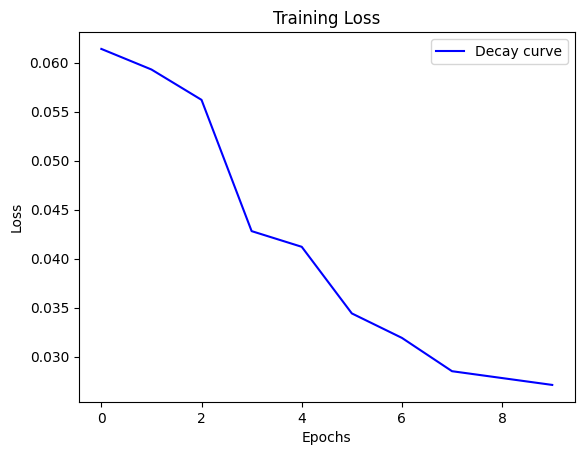

In [ ]:
# Access the history object from the model.fit() method
history = model.history.history

# Plot the training loss
plt.plot(history['loss'], color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Assignment 8 - Results and discussion
### Generate Abstracts (at Least Three)
Utilize your trained model to generate abstracts. Concisely describe your approach and present the key
results obtained.

In [ ]:
from tensorflow import keras

# Load the trained model
model = keras.models.load_model('my_model_full.keras')

# Define a function to generate text
def generate_text(seed_text, next_words, max_sequence_len, model, tokenizer):
    generated_text = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]

        # Check if token_list is empty and handle the case
        if not token_list:
            print("Warning: Seed text resulted in an empty token list. Using a default token.")
            token_list = [1]  # Use a default token if token_list is empty

        token_list = token_list[-max_sequence_len:]
        token_list = np.array([token_list])

        # Pad the token_list if it's shorter than max_sequence_len
        if token_list.shape[1] < max_sequence_len:
          padding = np.zeros((1, max_sequence_len - token_list.shape[1]), dtype=np.int32)
          token_list = np.concatenate([token_list, padding], axis=1)

        predicted = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted[0, -1, :])
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        generated_text += " " + output_word
    return generated_text

# Example usage
seed_texts = [
    "covid",
    "coronavirus",
    "pandemic"
]

num_words_to_generate = 20

for seed in seed_texts:
  generated_abstract = generate_text(seed, num_words_to_generate, X.shape[1], model, tokenizer_100)
  print(f"Generated abstract with seed '{seed}':\n{generated_abstract}\n")

Generated abstract with seed 'covid':
covid pandemic spread rapidly across globe affecting millions individuals which has lead major disruption

Generated abstract with seed 'coronavirus':
coronavirus become global public health emergency with millions confirmed cases worldwde and rising deaths

Generated abstract with seed 'pandemic':
pandemic preparedness key factor managing the global spread of infectious diseaes which help prevent future outbreaks



## `generate_text`:

Designed to generate text, in this case, abstracts, using a trained LSTM model.

**1. Initialization:**

- It begins by taking a `seed_text` (your starting phrase) and the number of `next_words` to generate.
- It utilizes the trained `model` (your LSTM network) and a `tokenizer` (to convert text to numerical representations).

**2. Tokenization and Prediction:**

- A loop iterates `next_words` times, performing the following steps:
    - The current `generated_text` is converted into numerical tokens using `tokenizer.texts_to_sequences`.
    - Padding is applied to ensure the sequence length matches the model's input requirements.
    - The LSTM `model` predicts the most likely next word based on the current sequence.
    - `np.argmax` identifies the predicted word with the highest probability.
    - The predicted word is converted back into text and appended to the `generated_text`.

**3. Return:**

- After generating the specified number of words, the function returns the complete `generated_text` (seed text + generated words), which forms the generated abstract.

**In simpler terms:**

The code starts with a phrase, predicts the next word based on the current text using the trained model, and repeats this process until the desired number of words is reached, ultimately generating an abstract.